In [ ]:
!pip install tabulate
!pip uninstall umap
!pip install umap-learn
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
!git clone https://github.com/ealeongomez/Data.git
!git clone https://github.com/ealeongomez/UMAPCDDA.git

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS remaining 24.12.* libraries
Using Python 3.11.11 environment at: /usr
Audited 11 packages in 170ms

        ***********************************************************************
        The pip install of RAPIDS is complete.

        Please do not run any further installation from the conda based installation methods, as they may cause issues!

        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files.
            - If an installation failure persists when using the latest script, please make an issue on https://github.com/rapidsai-community/rapidsai-csp-utils
        ***********************************************************************
       

# **Libraries**

In [ ]:
# Basic packages
import pandas as pd
import os, pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from umap import UMAP
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [ ]:
import cuml
import cudf
import os.path

from cuml.manifold.umap import UMAP as cuUMAP

In [ ]:
os.chdir('UMAPCDDA')


In [ ]:
# Define the name of the folder
path_res = "../results"

# Create the folder
os.makedirs(path_res, exist_ok=True)

In [ ]:
#from Experiments.Functions import ForecastingModels
#from Experiments.organizeData import selectSamples

# **Variables**

# **Load data**

# Read full datasets

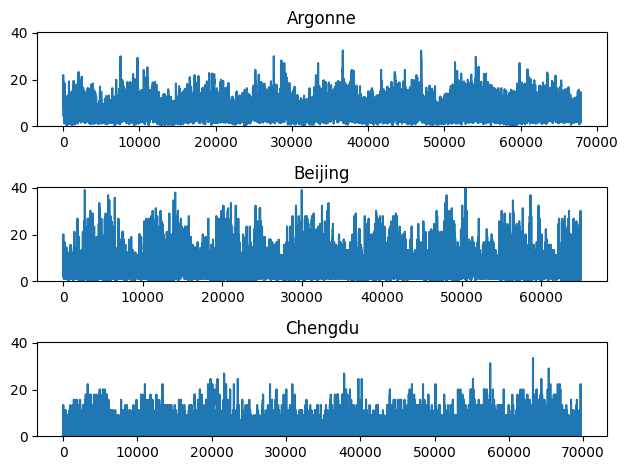

40.23500061035156


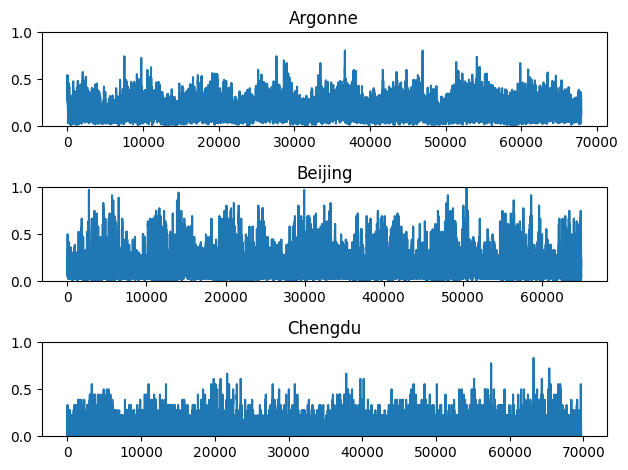

In [ ]:
#window size and prediction horizon
dataSet = {}
horizon_ = 7
window_ = 20
train_size = 0.8


#Argone
df_1 = pd.read_csv("../Data/WindSpeed/Argone_IL.txt", sep="\t",  names=['yyyymmdd','hhmn','mph','code'])
df_1 = df_1[df_1["yyyymmdd"] >= 19980101]
df_1["sped"] = pd.to_numeric(df_1["mph"], downcast="float")
timeSerie_1 = df_1.iloc[:,2].values

#Beijing
df_2 = pd.read_csv('../Data/WindSpeed/Beijing_Airport_China2.txt', delimiter=",")
df_2["sped"] = pd.to_numeric(df_2["sped"], downcast="float")
timeSerie_2 = df_2.iloc[:,1].values

#Chengdu
df_3 = pd.read_csv("../Data/WindSpeed/Chengdu_Airport_China.txt", sep=",")
df_3["sped"] = pd.to_numeric(df_3["sped "], downcast="float")
timeSerie_3 = df_3.iloc[:,2].values

max_ = np.max([np.max(timeSerie_1),np.max(timeSerie_2),np.max(timeSerie_3)])
names_ = ['Argonne','Beijing','Chengdu']

fig_,ax_ = plt.subplots(3,1)
ax_[0].plot(timeSerie_1)
ax_[0].set_ylim(0,max_)
ax_[0].set_title(names_[0])
ax_[1].plot(timeSerie_2)
ax_[1].set_title(names_[1])
ax_[1].set_ylim(0,max_)
ax_[2].plot(timeSerie_3)
ax_[2].set_title(names_[2])
ax_[2].set_ylim(0,max_)
plt.tight_layout()
plt.show()

time_series = [timeSerie_1/max_, timeSerie_2/max_, timeSerie_3/max_]
del df_1, df_2, df_3, timeSerie_1, timeSerie_2, timeSerie_3
print(max_)

fig_,ax_ = plt.subplots(3,1)
ax_[0].plot(time_series[0])
ax_[0].set_ylim(0,1)
ax_[0].set_title(names_[0])
ax_[1].plot(time_series[1])
ax_[1].set_title(names_[1])
ax_[1].set_ylim(0,1)
ax_[2].plot(time_series[2])
ax_[2].set_title(names_[2])
ax_[2].set_ylim(0,1)
plt.tight_layout()
plt.show()


(54315, 20) (54315, 7)
(13579, 20) (13579, 7)


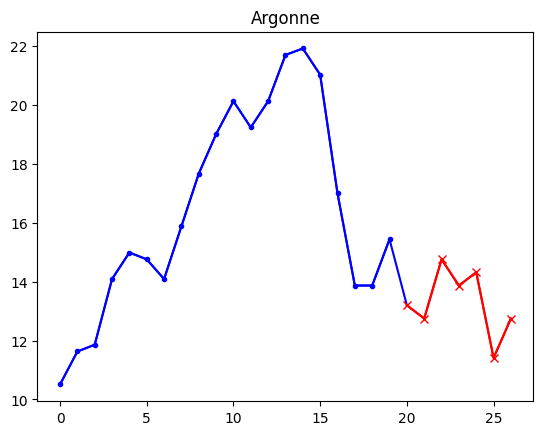

(51972, 20) (51972, 7)
(12994, 20) (12994, 7)


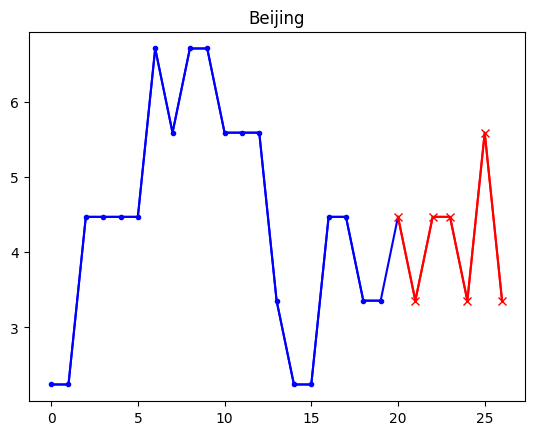

(55749, 20) (55749, 7)
(13938, 20) (13938, 7)


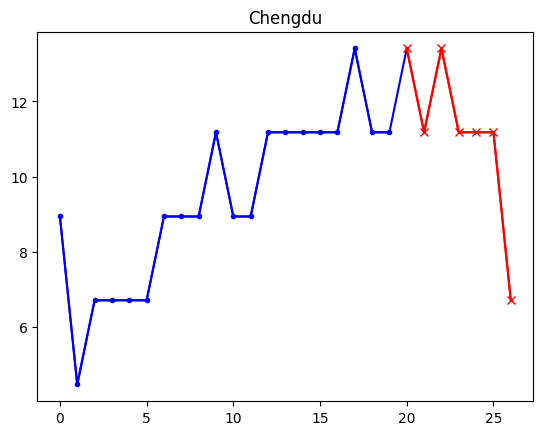

In [ ]:
for i,name in enumerate(names_):
  X_,y_ = selectSamples(time_series[i], horizon_, window_).SerieMatriz()
  N_ = X_.shape[0]
  dataSet.update({name:{'train': [X_[:int(train_size*N_)], y_[:int(train_size*N_)]], 'test':[X_[int(train_size*N_):], y_[int(train_size*N_):]] }})
  print(dataSet[name]['train'][0].shape,dataSet[name]['train'][1].shape)
  print(dataSet[name]['test'][0].shape,dataSet[name]['test'][1].shape)
  plt.plot(np.arange(0,window_+1),max_*np.r_[X_[0],y_[0][0]],c='b')
  plt.plot(np.arange(0,window_),max_*X_[0],marker='.',c='b')
  plt.plot(np.arange(window_,window_+horizon_),max_*y_[0],c='r')
  plt.plot(np.arange(window_,window_+horizon_),max_*y_[0],c='r',marker='x')
  plt.title(name)
  plt.show()



# UMAP

Umap over each dataset individually

In [ ]:
cuumap = cuUMAP(n_components=2,             # The dimension of the space to embed into.
                n_neighbors=30,             # The size of local neighborhood (from 1 to 100)
                #local_connectivity=1,       # rho
                random_state=42,
                #n_epochs=100,               # The number of iterations to run
                #learning_rate=0.01          # The learning rate
                )

In [ ]:
list(dataSet.keys())

['Argonne', 'Beijing', 'Chengdu']

	
 Argonne
	
 Beijing
	
 Chengdu


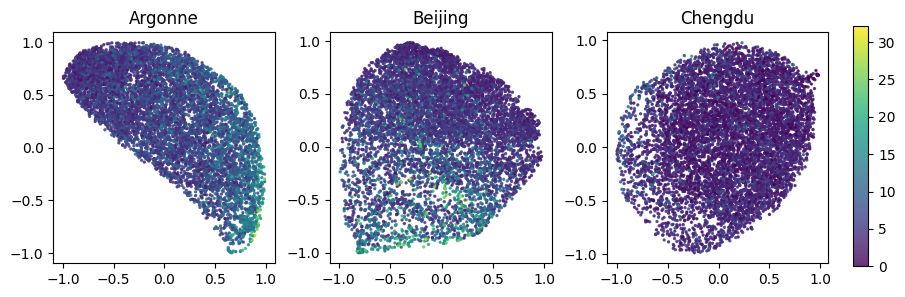

In [ ]:
names_ = list(dataSet.keys())

fig, ax = plt.subplots(1,len(names_),figsize=(10,3),gridspec_kw={'wspace': 0.25,'hspace': 0.5})

Ns_ = 8000

valm = np.zeros((len(names_),1))
for i, name in enumerate(names_):
    index = np.random.choice(dataSet[name]['train'][0].shape[0], size=Ns_, replace=False)
    Y_plot = max_*dataSet[name]['train'][1]#[index]
    valm[i] = np.max((np.mean(Y_plot, axis=1, keepdims=True)))


cuumap=[]
scaler=[]
for i, name in enumerate(names_):
    print("\t\n", name)
    X_plot = dataSet[name]['train'][0]#[index]
    Y_plot = max_*dataSet[name]['train'][1]#[index]
    norm_X_plot = (np.mean(Y_plot, axis=1, keepdims=True))
    if i == 0:
        Xc = X_plot
        Yc = Y_plot
        normc_ = norm_X_plot
        label_dat = (i+1)*np.ones((X_plot.shape[0],1))
    else:
        Xc = np.r_[Xc,X_plot]
        Yc = np.r_[Yc,Y_plot]
        normc_ = np.r_[normc_,norm_X_plot]
        label_dat = np.r_[label_dat,(i+1)*np.ones((X_plot.shape[0],1))]


    cuumap.append(cuUMAP(n_components=2,             # The dimension of the space to embed into.
                    n_neighbors=50,             # The size of local neighborhood (from 1 to 100)
                    random_state=42))
    scaler.append(MinMaxScaler(feature_range=(-1, 1)))

    umap_X_plot = cuumap[i].fit_transform(X_plot)
    umap_X_plot = scaler[i].fit_transform(umap_X_plot)

    index = np.random.choice(umap_X_plot.shape[0], size=Ns_, replace=False)

    val_ = ax[i].scatter(umap_X_plot[index, 0], umap_X_plot[index, 1], c=norm_X_plot[index], s=2,alpha=0.8,vmin=0,vmax=np.max(valm))
    ax[i].set_title(names_[i])
    ax[i].tick_params(axis="x", labelsize=10)
    ax[i].tick_params(axis="y", labelsize=10)
    ax[i].set_yticks([-1,-0.5,0,0.5,1])
    ax[i].set_xticks([-1,-0.5,0,0.5,1])

cbar_ax = fig.add_axes([0.925, 0.1, 0.015, 0.8])
fig.colorbar(val_, cax=cbar_ax) #,ticks=[np.min(normc_).round(2),
                                 #     (0.5*(np.max(normc_)-np.min(normc_))).round(1),
                                 #     np.max(normc_).round(2)])
cbar_ax.tick_params(labelsize=10)
plt.tight_layout()
plt.savefig(path_res+"/umap_datasets.pdf", format='pdf')
plt.show()


In [ ]:
from scipy.spatial.distance import cdist

#logspace threshold
#maximum radius
thmin = 1e-2
thmax = 3e-1
num_ = 10
#max_d = (cdist(np.array([-1,-1]).reshape(1,-1),np.array([1,1]).reshape(1,-1))/5)[0]
ths = np.logspace(np.log10(thmin), np.log10(thmax), num=num_)
ths = np.array([1e-3,2e-3,5e-3,7e-3,1e-2,2e-2])
print(ths.round(3))

[0.001 0.002 0.005 0.007 0.01  0.02 ]


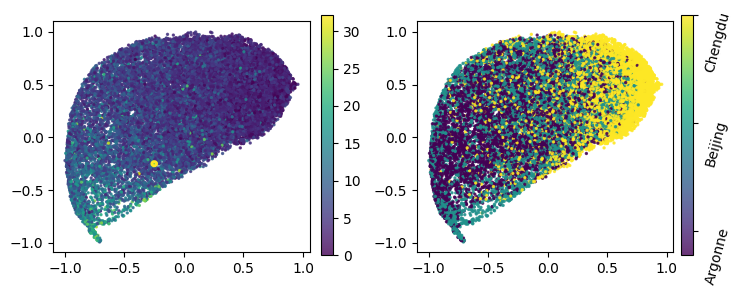

In [ ]:
#umap among datasets
scaler_all = MinMaxScaler(feature_range=(-1, 1))

umap_all = cuUMAP(n_components=2,
                  n_neighbors=30,
                  random_state=42)

Z = umap_all.fit_transform(Xc)
Z = scaler_all.fit_transform(Z)

fig, ax = plt.subplots(1,2,figsize=(8,3),gridspec_kw={'wspace': 0.42,'hspace': 0.4})

Ns_ = 20000
index = np.random.choice(Z.shape[0], size=Ns_, replace=False)

val_ = ax[0].scatter(Z[index,0],Z[index,1], c=normc_[index],s=2,alpha=0.8,vmin=0,vmax=np.max(normc_))
ax[0].tick_params(axis="x", labelsize=10)
ax[0].tick_params(axis="y", labelsize=10)
ax[0].set_yticks([-1,-0.5,0,0.5,1])
ax[0].set_xticks([-1,-0.5,0,0.5,1])

cmap = plt.get_cmap("viridis", len(ths))
for jj, th in enumerate(ths):
    color = cmap(jj / len(ths))
    circle = plt.Circle((-0.25, -0.25), th, color=color, fill=False, linewidth=2)
    ax[0].add_patch(circle)


cbar_ax = fig.add_axes([0.46, 0.1, 0.015, 0.8])
fig.colorbar(val_, cax=cbar_ax)#,ticks=[np.min(normc_).round(1),
                                #      0.5*(np.max(normc_)-np.min(normc_)).round(1),
                                 #     np.max(normc_).round(1)])

val_ = ax[1].scatter(Z[index,0],Z[index,1], c=label_dat[index], s=2, alpha=0.8, vmin=np.min(label_dat), vmax=np.max(label_dat))

ax[1].tick_params(axis="x", labelsize=10)
ax[1].tick_params(axis="y", labelsize=10)
ax[1].set_yticks([-1,-0.5,0,0.5,1])
ax[1].set_xticks([-1,-0.5,0,0.5,1])

cbar_ax = fig.add_axes([0.91, 0.1, 0.015, 0.8])
cbar = fig.colorbar(val_, cax=cbar_ax,ticks=[1.2,2.1,3])
cbar.ax.set_yticklabels(['Argonne', 'Beijing', 'Chengdu'],rotation=75)


#plt.tight_layout()
plt.savefig(path_res+"/umap_radius.pdf", format='pdf')
plt.show()

# Select Samples

In [ ]:
from cuml.metrics.pairwise_distances import pairwise_distances as cumdis
import cupy as cp

def UMAPDA(Z,label_dat,Nsc=25000,plot_ = False):
    '''
    UMAP data augmentation
    Z \in N x 2 -> umap low dimensional space
    N = sum N_r -> total number of samples
    N_r samples in r-th dataset
    label_dat \in {1,2,...,R} database index
    Nsc < N subsampling per class
    '''
    #number of samples per datasets
    Nc = np.zeros((len(np.unique(label_dat))))
    for i in range(len(np.unique(label_dat))):
        Nc[i] = sum(label_dat==i+1)
    print(Nc)

    #subsampling per class
    index_c = np.zeros((Nsc,len(Nc)))
    for i in range(len(Nc)):
        index_c[:,i] = np.random.choice(int(Nc[i]), size=Nsc, replace=False)

    index_total = np.arange(0,label_dat.shape[0]) #index full samples

    ind_dat = np.unique(label_dat) #numper of databases R
    D = []
    ind_target = []
    ind_source = []
    for j,c in enumerate(ind_dat):
        print(c)
        ind_source.append(index_total[(label_dat==c).ravel()][index_c[:,j].astype(int)].astype(int))
        ind_target_ = np.empty(0)
        for cc in ind_dat[ind_dat!=c]:
            ind_target_ = np.r_[ind_target_, index_total[(label_dat==cc).ravel()][index_c[:,int(cc-1)].astype(int)]].astype(int)
        ind_target.append(ind_target_)

        Nsource = len(ind_source[j])
        Ntarget = len(ind_target[j])


        dc = np.zeros((len(ind_source[j]),len(ind_target[j])))
        batch_size = 5000
        for jj in range(0, Ntarget, batch_size):
            end_index = min(jj + batch_size, Ntarget)
            dc[:, jj:end_index] = cp.asnumpy(cumdis(cp.array(Z[ind_source[j]]),
                                                    cp.array(Z[ind_target[j][jj:end_index]])))

        #dc = cumdis(cp.array(Z[ind_source[j]]),cp.array(Z[ind_target[j]]
        #D.append(cumdis(cp.array(Z[ind_source[j]]),cp.array(Z[ind_target[j]])))
        D.append(dc)
        del dc

        if plot_:
            Nd,Pd = cp.asnumpy(D[j]).shape
            if Nd > 5000:
               indn = np.random.choice(Nd, size=5000, replace=False)
            else:
               indn = int(np.arange(0,Nd))
            if Pd > 10000:
              indp = np.random.choice(Pd, size=10000, replace=False)
            else:
              indp = int(np.arange(0,Pd))
            plt.imshow(cp.asnumpy(D[j][indn,:][:,indp]))
            plt.colorbar()
            plt.show()
    return index_total, ind_source, ind_target, D


def ind_UMAPCD(index_total,ind_source,ind_target,D,ths):

  index_aug = []
  for i in range(len(D)):
    wh = np.where(cp.asnumpy(D[i])<ths)
    ind_u = np.unique(wh[1])
    index_aug.append(index_total[ind_target[i][ind_u]])
  return index_aug




In [ ]:
Nsc = 30000 #subsamples
ind_total, ind_source, ind_target, D = UMAPDA(Z,label_dat,
                                              Nsc=Nsc,plot_ = False)

[54315. 51972. 55749.]
1.0
2.0
3.0


In [ ]:
ind_total_aug = [[None for _ in range(len(D))] for _ in range(len(ths))]
for i in range(len(D)):
  for j in range(len(ths)):
    print(f"UMAPDA {names_[i]} $\zeta$={ths[j].round(3)}--{j+1}/{len(ths)}")
    wh = np.where(cp.asnumpy(D[i])<ths[j])
    ind_u = np.unique(wh[1])
    ind_total_aug[j][i] = ind_total[ind_target[i][ind_u]]
    #ind_total_aug thresholds vs Datasets


UMAPDA Argonne $\zeta$=0.001--1/6
UMAPDA Argonne $\zeta$=0.002--2/6
UMAPDA Argonne $\zeta$=0.005--3/6
UMAPDA Argonne $\zeta$=0.007--4/6
UMAPDA Argonne $\zeta$=0.01--5/6
UMAPDA Argonne $\zeta$=0.02--6/6
UMAPDA Beijing $\zeta$=0.001--1/6
UMAPDA Beijing $\zeta$=0.002--2/6
UMAPDA Beijing $\zeta$=0.005--3/6
UMAPDA Beijing $\zeta$=0.007--4/6
UMAPDA Beijing $\zeta$=0.01--5/6
UMAPDA Beijing $\zeta$=0.02--6/6
UMAPDA Chengdu $\zeta$=0.001--1/6
UMAPDA Chengdu $\zeta$=0.002--2/6
UMAPDA Chengdu $\zeta$=0.005--3/6
UMAPDA Chengdu $\zeta$=0.007--4/6
UMAPDA Chengdu $\zeta$=0.01--5/6
UMAPDA Chengdu $\zeta$=0.02--6/6


In [ ]:
'''
import seaborn as sns

for i in range(len(D)):
  print(i)
  # Convert the cupy array to a numpy array.
  d_numpy = cp.asnumpy(D[i]).ravel()
  L = len(d_numpy)
  hmin_ = 5000
  if L > 15000:
     ind = np.random.choice(L, size=hmin_, replace=False)
     d_numpy = d_numpy[ind]



  # Create a histogram using matplotlib.
  plt.hist(d_numpy, bins=50, label=names_[i], alpha=0.5)

# Add a title and legend to the plot.
plt.legend()

# Show the plot.
plt.show()
'''

'\nimport seaborn as sns\n\nfor i in range(len(D)):\n  print(i)\n  # Convert the cupy array to a numpy array.\n  d_numpy = cp.asnumpy(D[i]).ravel()\n  L = len(d_numpy)\n  hmin_ = 5000\n  if L > 15000:\n     ind = np.random.choice(L, size=hmin_, replace=False)\n     d_numpy = d_numpy[ind]\n\n\n\n  # Create a histogram using matplotlib.\n  plt.hist(d_numpy, bins=50, label=names_[i], alpha=0.5)\n\n# Add a title and legend to the plot.\nplt.legend()\n\n# Show the plot.\nplt.show()\n'

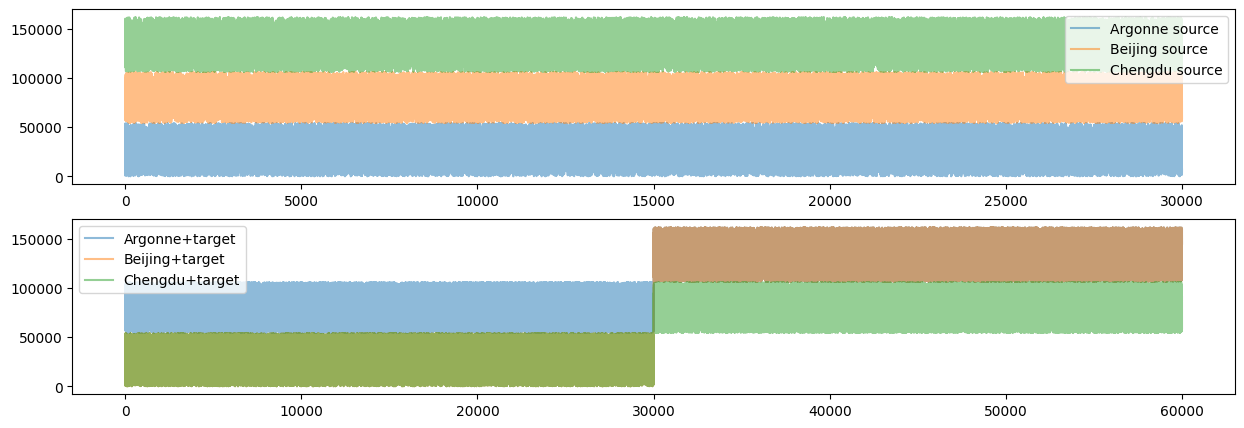

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(15,5))
for i in range(len(ind_source)):
  ax[0].plot(ind_source[i],label=f"{names_[i]} source",alpha=0.5)
  ax[1].plot(ind_target[i],label=f"{names_[i]}+target",alpha=0.5)
ax[0].legend()
ax[1].legend()
plt.show()


Argonne $\zeta=$0.001...Nr=54315 to N=56467 %DA=4.0
Argonne $\zeta=$0.002...Nr=54315 to N=62331 %DA=14.8
Argonne $\zeta=$0.005...Nr=54315 to N=85945 %DA=58.2
Argonne $\zeta=$0.007...Nr=54315 to N=96553 %DA=77.8
Argonne $\zeta=$0.01...Nr=54315 to N=103602 %DA=90.7
Argonne $\zeta=$0.02...Nr=54315 to N=109345 %DA=101.3
Beijing $\zeta=$0.001...Nr=51972 to N=54623 %DA=5.1
Beijing $\zeta=$0.002...Nr=51972 to N=61631 %DA=18.6
Beijing $\zeta=$0.005...Nr=51972 to N=87687 %DA=68.7
Beijing $\zeta=$0.007...Nr=51972 to N=97508 %DA=87.6
Beijing $\zeta=$0.01...Nr=51972 to N=103543 %DA=99.2
Beijing $\zeta=$0.02...Nr=51972 to N=107171 %DA=106.2
Chengdu $\zeta=$0.001...Nr=55749 to N=57710 %DA=3.5
Chengdu $\zeta=$0.002...Nr=55749 to N=62864 %DA=12.8
Chengdu $\zeta=$0.005...Nr=55749 to N=80622 %DA=44.6
Chengdu $\zeta=$0.007...Nr=55749 to N=88839 %DA=59.4
Chengdu $\zeta=$0.01...Nr=55749 to N=97053 %DA=74.1
Chengdu $\zeta=$0.02...Nr=55749 to N=108417 %DA=94.5


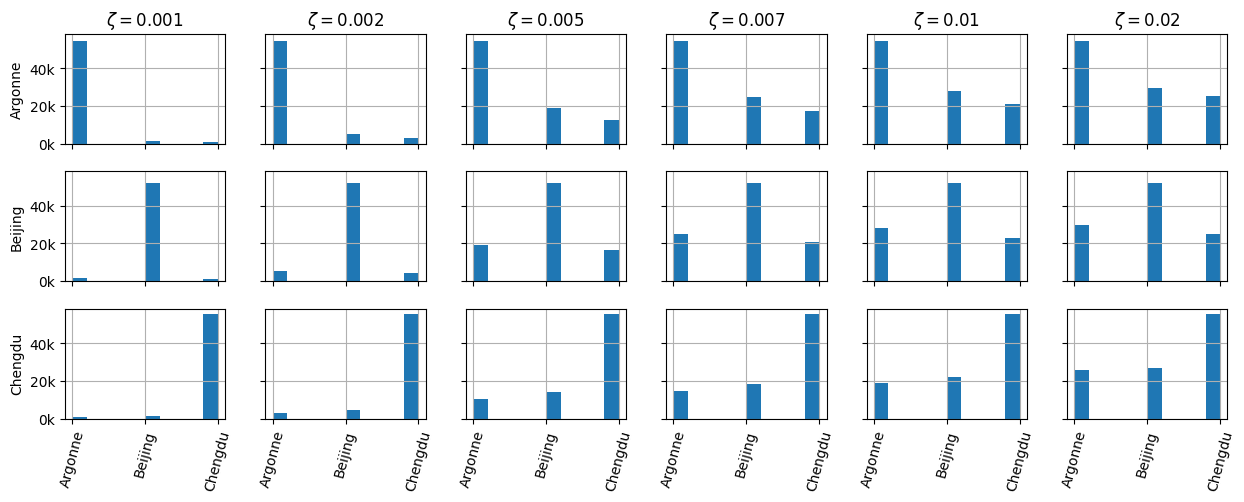

In [ ]:
import matplotlib.ticker as ticker
def format_ticks(x, pos):
    return f'{int(x/1000)}k'

datas_ = len(names_)
Nths = len(ths)
fig,ax = plt.subplots(datas_,Nths,figsize=(15,5),sharex=True,sharey=True)

aum_ = np.zeros((datas_,Nths))

for d_ in range(datas_):
  for th_ in range(Nths):
     vec_ = np.append(label_dat[label_dat==d_+1],
                               label_dat[ind_total_aug[th_][d_]])
     ax[d_,th_].hist(vec_,density=False)#,alpha=0.5)
     ax[d_,th_].set_xticks([])
     ax[d_,th_].yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
     ax[d_,th_].grid()
     aum_[d_,th_] = (100*(len(vec_)-np.sum(label_dat==d_+1))/np.sum(label_dat==d_+1)).round(1)
     print(f"{names_[d_]} $\zeta=${ths[th_].round(3)}...Nr={np.sum(label_dat==d_+1)} to N={len(vec_)} %DA={aum_[d_,th_]}")
for d_ in range(datas_):
  ax[d_,0].set_ylabel(names_[d_],rotation=90)


for th_ in range(Nths):
  ax[0,th_].set_title(f"$\zeta=${ths[th_].round(3)}")
  ax[-1,th_].set_xticks([1,2,3])
  ax[-1,th_].set_xticklabels(names_,rotation=75)



plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig(path_res+"/umapda.pdf", format='pdf',bbox_inches='tight')
plt.show()

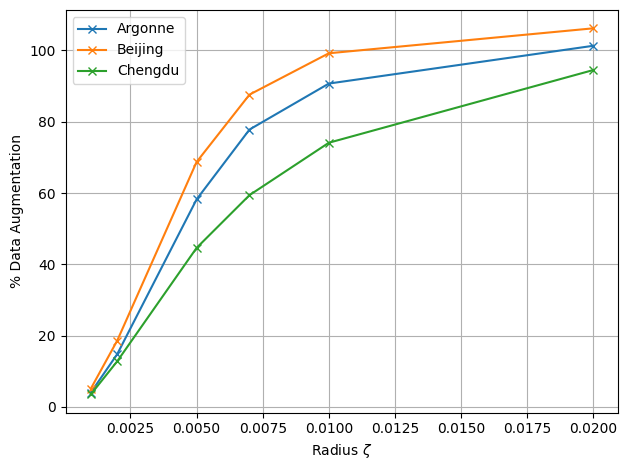

In [ ]:
#fig,ax = plt.subplots(1,datas_,figsize=(8,4),sharex=True,sharey=True)

#plt.plot(ths,aum_.T,marker='.')
plt.plot(ths,aum_.T,label=names_,marker='x')

plt.xlabel('Radius $\zeta$')
plt.ylabel('% Data Augmentation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(path_res+"/perDA.pdf", format='pdf')
plt.show()


In [ ]:
print(np.min(Xc),np.max(Xc))
print(np.min(Yc),np.max(Yc))

0.0 1.0
0.0 40.23500061035156


In [ ]:
data_UMAPDA = {'Xc':Xc,'Yc':Yc,'names_':names_,'label_dat':label_dat,'max_':max_,
               'ths':ths,'ind_total':ind_total, 'ind_source':ind_source, 'ind_target':ind_target,
               'ind_total_aug':ind_total_aug}

In [ ]:
import joblib #https://joblib.readthedocs.io/en/latest/
joblib.dump(data_UMAPDA, "../results/data_UMAPDA.pkl") # DIFF  https://docs.python.org/2/library/pickle.html
#...
#my_model_loaded = joblib.load("results/data_UMAPDA.pkl") # to laod

['../results/data_UMAPDA.pkl']

In [ ]:
#guardar resultados
from google.colab import files
from datetime import date, datetime
import shutil
#guardar resultados
namefile = str(datetime.now().strftime("%Y_%m_%d_%H_%M_%d"))+'__results'
shutil.make_archive(namefile, 'zip', '../results')
files.download(namefile+'.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ths

array([0.001, 0.002, 0.005, 0.007, 0.01 , 0.02 ])